In [1]:
# in this example, we will demonstrate how optimial transport may be combined with the Gerchberg-Saxton algorithm to solve the phase retrieval problem for a given target beam profile
# we will assume a synthetically generate input beam profile defined on a 2d Grid comensurate with the spatial resolution of the SLM
# This approximation will not be valid for real conditions, where the SLM itself distorts the beam profile in intensity and phase
using SLMTools

In [2]:
# define the SLM grid parameters. these are determined by the SLM itself
N_SLM_x = 1024 # number of rows in the SLM 
N_SLM_y = 1024 # number of columns in the SLM 
SLM_pixel_size = 17.0 # microns
L_SLM_pixels = (1:N_SLM_x,1:N_SLM_y) # the SLM grid, in pixels
L_SLM_microns = ((L_SLM_pixels[1] .- N_SLM_x/2).*SLM_pixel_size, (L_SLM_pixels[2] .- N_SLM_y/2).*SLM_pixel_size) # the SLM grid, in microns, centered at the origin

# define the target grid parameters, these are dtermined by the camera used to measure the beam profile at the target plane
# the camera is assumed to be placed at the focal plane of a lens
# for this demonstration, we can imagine a fictional camera with whatever parameters we like
N_target_x = 500 # number of rows in the target grid
N_target_y = 700 # number of columns in the target grid
target_pixel_size = 5.2 # microns
L_target_pixels = (1:N_target_x,1:N_target_y) # the target grid, in pixels
L_target_microns = ((L_target_pixels[1] .- N_target_x / 2) .* target_pixel_size, (L_target_pixels[2] .- N_target_y / 2) .* target_pixel_size) # the target grid, in microns

(-1294.8:5.2:1300.0000000000002, -1814.8:5.2:1820.0000000000002)

,

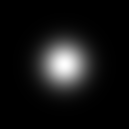
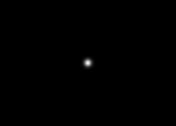

In [3]:
# let's now define the initial beam profile on the SLM. 
# In real conditions, this would be the beam profile determined by Phase Diversity methods, but for this example, we will assume a synthetically generated beam profile
sigma = 2*1000 # in microns
input_beam = lfGaussian(Intensity, (1024,1024),sigma, L=L_SLM_microns) # the input beam profile, defined on the SLM grid. the second argument (sz) is unused since we supply the grid directly


# let's now define the target beam profile. this is always synthetically generated
# note that the target profile is dramatically smaller than the SLM grid and input beam
r_ring = 50.0 # microns
w_ring = 10.0 # microns
# target_beam = lfRing(Intensity, (N_target_x, N_target_y), r_ring, w_ring, L=L_target_microns)
target_beam = lfGaussian(Intensity, (N_target_x, N_target_y), 50, L=L_target_microns)
# the target beam profile, defined on the target grid. the second argument (sz) is unused since we supply the grid directly
[look(input_beam), look(target_beam)]

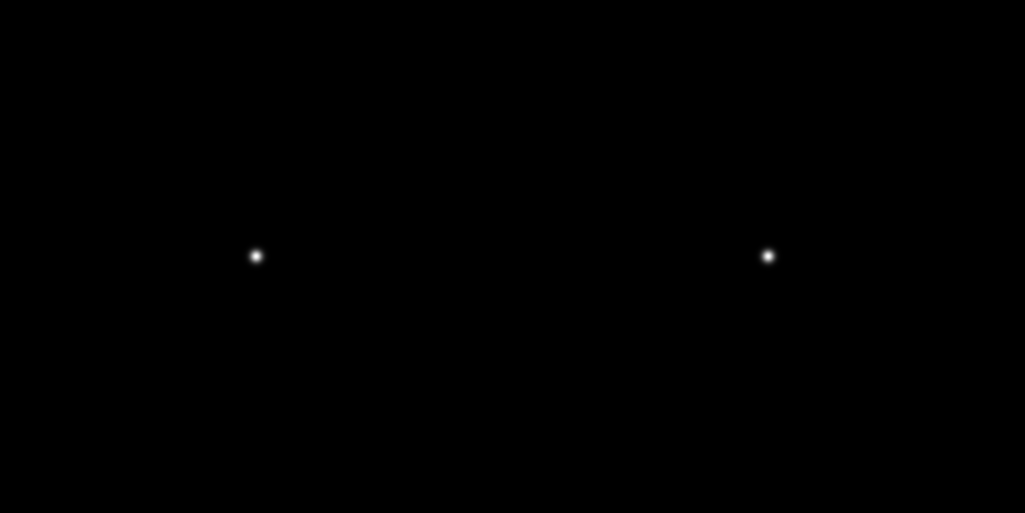

In [4]:
# now we have our input and desired output. To proceed, we must remap the input and output grids to be dual to each other
# this is done by the function dualate, which takes the target LatticeField object and interpolates it on to a new lattice, dual to the SLM/source grid
# dualate also requires the center and angle of how the target grid is rotated with respect to the SLM grid, 
# this is due to experimental constraints, which we will ignore for this example by setting the angle to 0 and the center to the origin
# in real conditions, the angle and center must be determined by getOrientation on calibration images
flambda = 1.064*100*1000 #f lambda product in microns^2, changing this will change the resolution of the dual grid!
dual_target_beam_normal = dualate(target_beam, L_SLM_microns, [0, 0], 0, flambda; naturalize=false)
dual_target_beam_natural = dualate(target_beam, L_SLM_microns, [0, 0], 0, flambda; naturalize=true)
# we've now created two dual target beam profiles, one natural and one not. the data are identical, we will see in the next cell how they are different
[look(dual_target_beam_normal) look(dual_target_beam_natural)]

In [5]:
# lets print the lattices of the normal and natural dualuated target beam profiles
println(dual_target_beam_normal.L[1]) # this lattice is in units of microns
println( dual_target_beam_natural.L[1]) # this lattice is in "dualcrons" which is a new unit defined by the naturalize function
# dualcron is the stepsize of the following
println(dualShiftLattice(L_SLM_microns, flambda)[1])
# more concretely, its dualcron= flambda_in_squaremicrons/Length_SLM_in_microns, where Length_SLM is the length (in microns) of the lattice
dualcron = flambda / (L_SLM_microns[1][end] - L_SLM_microns[1][1] + SLM_pixel_size) # the dualcron, in microns
# so the lattices are identical, except the dualuated lattice is in dualcrons instead of microns

-3129.4117647058824:6.112132352941177:3123.299632352941
-16.0:0.03125:

15.96875
-3129.4117647058824:6.112132352941177:3123.299632352941


6.112132352941177

In [18]:
# now we have our input and desired output, and we have dualuated the target beam profile, we can now proceed to generating the phase mask
# our first step is to get the initial guess for the required phase profile on the SLM using Optimal Transport
# this part of the calulation doesn't actually depend on the duality of the two profiles, but the next step does
# however, the OT algorithm scales with the *total number of pixels* in the input and output profiles, so we must downsample
# the scaling is O(N^4)
OT_input_beam = coarsen(input_beam, 8) # downsample the input beam profile via averaging

hL1,hL2 = size(target_beam) .÷ 2
hw = 35
# OT_target_beam = target_beam[hL1-hw:hL1+hw-1, hL2-hw:hL2+hw-1] # crop the target beam profile
OT_target_beam = coarsen(target_beam, 8) # downsample the target beam profile via averaging
println(size(OT_input_beam), size(OT_target_beam))
OT_guess = otPhase(OT_input_beam, OT_input_beam, 0.01)
[look(OT_input_beam), look(OT_target_beam), look(OT_guess)]


DomainError: DomainError with (8, 500):
downsample: Downsample factor n does not divide the length of the range r.

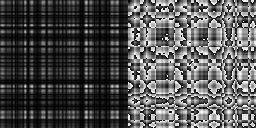

In [17]:
# OT_guess.data .= zero(Float64)
out = sft((OT_input_beam |> sqrt) * OT_guess)
look(out)

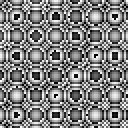

In [8]:
look(OT_guess)

In [9]:
OT_guess.data .= zero(Float64)


64×64 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                 ⋮              
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     